## Check the GWAS results

Let's read in the raw GWAS results filter, associations with a p<1e-5 and create an overview.

In [1]:
import pandas as pd
from rich.progress import track
from glob import glob
from os.path import basename

files = glob("data/gwas_filtered/*.tsv.gz")
final = []
for fi in track(files):
    try:
        gwas = pd.read_csv(fi, sep="\t")
    except pd.errors.EmptyDataError:
        continue
    if not "P" in gwas.columns:
        continue
    gwas["metabolite"] = basename(fi).split(".tsv")[0].replace("filtered_", "")
    final.append(gwas)
final = pd.concat(final)

Output()

In [2]:
final

,CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P,metabolite
0,15,rs147955703,41918035,A,G,1000,0.0060,-0.620888,0.136803,5.664420e-06,metabolite_100000997
1,15,rs146819334,55834900,A,G,1000,0.0130,-0.465256,0.093412,6.336560e-07,metabolite_100000997
2,16,rs142656671,6406759,A,G,1000,0.0180,0.354406,0.079999,9.417340e-06,metabolite_100000997
3,16,rs75446625,77757141,G,C,1000,0.0615,0.195718,0.043393,6.470670e-06,metabolite_100000997
4,16,rs160197,77760157,C,T,1000,0.7135,-0.120304,0.023057,1.812160e-07,metabolite_100000997
...,...,...,...,...,...,...,...,...,...,...,...
106,8,rs149090860,66714393,C,T,1000,0.0105,-0.525166,0.116832,6.954760e-06,metabolite_999952843
107,8,rs72652802,67681938,G,A,1000,0.1260,-0.171996,0.035294,1.098040e-06,metabolite_999952843
108,8,rs72654908,67745874,T,C,1000,0.1140,-0.176016,0.036679,1.595610e-06,metabolite_999952843
109,9,rs10965499,22889446,T,G,1000,0.4165,-0.112291,0.023932,2.703530e-06,metabolite_999952843


In [3]:
max_pos = pd.read_csv("data/grch37_chr.tsv", index_col=0, sep="\t", header=None).iloc[:, 0]
max_pos[0] = 0
max_pos.sort_index(inplace=True)

In [4]:
final["absolute_position"] = final.POS + max_pos.sort_index().cumsum()[final.CHR - 1].values
final = final.sort_values(by=["CHR", "POS"]).reset_index(drop=True)

In [5]:
import numpy as np

final["neg_log_p"] = - np.log10(final.P) 

<ipython-input-6-fb9ad7de544c>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


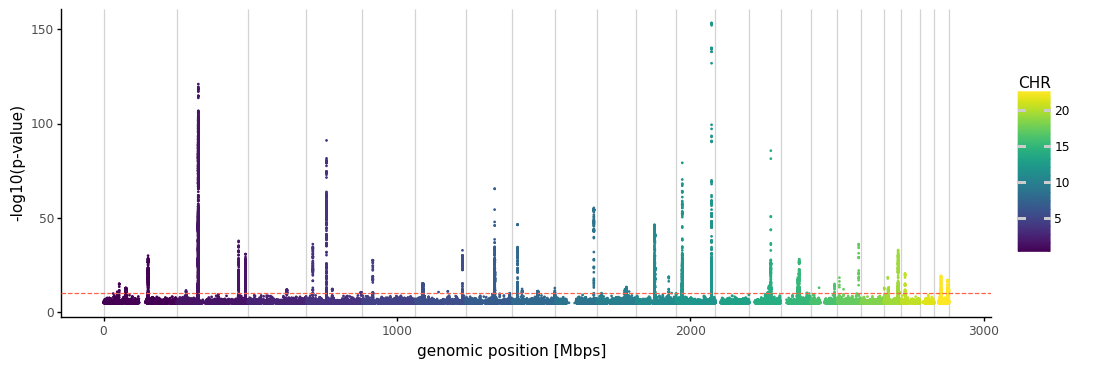

<ggplot: (8754058948337)>

In [6]:
from plotnine import *
theme_set(theme_classic())

stripes = pd.Series(index=final.CHR.unique())
stripes[stripes.index] = "darkblue"
stripes[stripes.index % 2 == 0] = "lightblue"

chr_anns = pd.DataFrame({"x": max_pos.cumsum() / 1e6, "y": 100, "label": max_pos.index})

mh = (
    ggplot(final) + 
    geom_vline(xintercept=chr_anns.x, color="lightgray") +
    aes(x="absolute_position / 1e6", y="neg_log_p", color="CHR") +  
    geom_point(size=0.1) + 
    geom_hline(yintercept=-np.log10(5.8e-11), linetype="dashed", color="tomato") +
    theme(figure_size=(12, 4)) +
    labs(x = "genomic position [Mbps]", y="-log10(p-value)")
)
mh

In [7]:
final

,CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P,metabolite,absolute_position,neg_log_p
0,1,rs149168804,828539,T,A,1000,0.0195,0.344557,0.075560,0.000005,metabolite_100001856,828539,5.291215
1,1,rs143299207,1057989,T,G,1000,0.0110,-0.210331,0.047227,0.000008,metabolite_100008915,1057989,5.073465
2,1,rs143299207,1057989,T,G,1000,0.0110,-0.312722,0.069828,0.000008,metabolite_100015791,1057989,5.123915
3,1,rs116679929,1232299,T,G,1000,0.0135,0.387749,0.080832,0.000002,metabolite_100021918,1232299,5.792993
4,1,rs192694927,1266475,T,C,1000,0.0145,0.366829,0.078111,0.000003,metabolite_100021918,1266475,5.576723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102681,22,rs7284429,51033840,G,C,1000,0.5405,-0.037550,0.007937,0.000002,metabolite_100001446,2880762560,5.651063
102682,22,rs131744,51034177,A,G,1000,0.6510,-0.036511,0.008056,0.000006,metabolite_100001446,2880762897,5.233293
102683,22,rs131743,51034867,C,T,1000,0.6535,-0.039240,0.008079,0.000001,metabolite_100001446,2880763587,5.924420
102684,22,rs131741,51034961,T,C,1000,0.6570,-0.039035,0.008109,0.000001,metabolite_100001446,2880763681,5.829718


In [8]:
final.reset_index(drop=True, inplace=True)